In [576]:
# import all modules here
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import quad, simpson, dblquad
from scipy.special import jv # bessel function of the first kind
import seaborn as sns
sns.set()
sns.set_style("white")

# Numerical

We want to arrive at a value for the photocurrent $I\left(k_x,k_y,\omega,t_0\right)$. To do so, we must:
- Diagonalize the TISE $h_{\mathbf{k}}\phi_{\mathbf{k}\alpha} = E_{\mathbf{k}\alpha}\phi_{\mathbf{k}\alpha}$;
- Integrate the TDSE $i\hbar\partial_t\psi_{\mathbf{k}\alpha}\left(t\right) H_{\mathbf{k}}\psi_{\mathbf{k}\alpha}\left(t\right)$ with $\psi_{\mathbf{k}\alpha}\left(t\to-\infty\right) =\phi_{\mathbf{k}\alpha}$ as an initial condition;
- Use the states $\psi_{\mathbf{k}\alpha}\left(t\right)$ found above to compute the lesser Green function $G^{<}_{\mathbf{k}\sigma\sigma'}\left(t_1,t_2\right)$ and its Trace;
- Compute the photocurrent by integrating $I\left(k_x,k_y,\omega,t_0\right) = \sum_{\sigma\alpha} f\left(E_{\mathbf{k}\alpha}\right)\left|\int dt \, s\left(t,t_0\right) e^{i\omega t} \psi^{\sigma}_{\mathbf{k}\alpha}\left(t\right)\right|^2$.

Let's start by a simple diagonalization routine to obtain $\phi$ and $E$.

In [384]:
# define all variables
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

hbar = 0.6582119569 # ev * fs
v = 3.6/hbar # Ang/fs
Omega = 0.12/hbar # fs^-1
Tpump = 106.16 # fs
Tprobe = 26 # fs
eE0 = 7.5e-3 # eV Ang
mu = 0.3 # eV
wf = mu/hbar # fs^-1


# t0 = 1
# w = 1

In [385]:
def InitialConditions(kx,ky,v,mu):
    """
    Returns phi and E for the time-independent Hamiltonian
    phi[:,alpha] is the alpha'th eigenvector
    """
    # initial Hamiltonian
    hk = hbar*v*kx*s2 - hbar*v*ky*s1 - mu*s0
    
    # diagonalize it
    E, phi = np.linalg.eigh(hk)
    
    return E, phi

Next, define the time-dependent differential Schrodinger equation $\partial_t \psi = f\left(t,\psi\right) \psi$:

In [386]:
def fun(t,psi,kx,ky,v,mu,eE0,Omega,Tpump):
    # kinetic energy part
    K = hbar*v*kx*s2 - hbar*v*ky*s1 - mu*s0
    # floquet pump part
    A = -v * eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.cos(Omega*t) * s2
    # hamiltonian
    H = K + A 
    # TDSE d psi / dt = (below)
    f = -1j/hbar * H @ psi
    return f

Now that we've tested that, we're going to want to solve it for many $k_x$ and $k_y$. This is probably not the most efficient way to do it, but it'll do. We could alternatively do it from scratch ourselves with a Crank-Nicholson method, for example. 

The next step is to integrate the wavefunction, phase factor and enveloppe function (for each spin and eigenstate). Then, we take the modulus squared and sum over all of these, weighting each by a Fermi function.

In [417]:
def Enveloppe(t,t0,Tprobe):
    """
    Probe pulse enveloppe function
    """
    return np.exp(-(t-t0)**2/(2*Tprobe**2))

def Fermi(E,kT):
    """
    Fermi distribution
    """
    f = 1/(np.exp(E/kT) + 1)
    return f

In [634]:
def PhotocurrentSA(psi,s,kx,ky,w,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    # t-space
    t_space = psi.t
#     integrand: enveloppe * phase * psi
    integrand = Enveloppe(t_space,t0,Tprobe) * np.exp(1j*w*t_space) * psi.y[s,:]
    # integrate samples data using simpson's rule
    I = simpson(integrand,x=t_space)
    return np.abs(I)**2

def Photocurrent(kx,ky,w,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Main photocurrent function
    """
    # start by diagonalizing time-independent system
    Es, phis = InitialConditions(kx,ky,v,mu)
    
    # solve ODE
    psi0 = solve_ivp(fun=fun, t_span=[-600,500], y0=phis[:,0], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')
    psi1 = solve_ivp(fun=fun, t_span=[-600,500], y0=phis[:,1], args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45')
    
    # integrate and add it up
    P = 0
    for s in range(2):
        # add up both spins
        P += Fermi(Es[0],kT=1e-4) * PhotocurrentSA(psi0,s=s,kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe) 
        P += Fermi(Es[1],kT=1e-4) * PhotocurrentSA(psi1,s=s,kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
    return P

def PhotocurrentArray(kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in kx-w plane 
    """
    res = 100
    kxs = np.linspace(-0.1,0.1,res)
    ws = np.linspace(-3,3,res)*Omega - mu/hbar # from inverting (w-wF)/Omega
    
#     P = np.zeros((res,res),dtype=float)
    
#     for i in range(res):
#         kx = kxs[i]
#         for j in range(res):
#             w = ws[j]
#             P[i,j] = Photocurrent(kx,ky,w,t0)

    P = np.zeros(res,dtype=float)
    for i in range(res):
        w = ws[i]
        P[i] = Photocurrent(kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P
    

In [635]:
ws5, Ps5 = PhotocurrentArray(kx=0.05,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
# ws1, Ps1 = PhotocurrentArray(kx=0.05,ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
# ws0, Ps0 = PhotocurrentArray(kx=0.05,ky=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

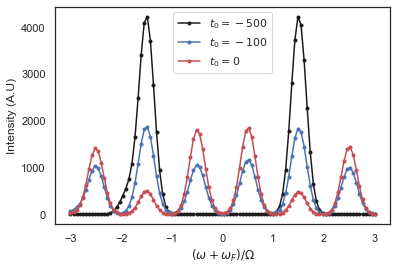

In [636]:
plt.plot((ws5+wf)/Omega,Ps5,c='k',marker='.',label=r"$t_0 = -500$")
plt.plot((ws1+wf)/Omega,Ps1,c='b',marker='.',label=r"$t_0 = -100$")
plt.plot((ws0+wf)/Omega,Ps0,c='r',marker='.',label=r"$t_0 = 0$")
plt.legend()
plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.ylabel(r"Intensity (A.U)")
plt.show()

In [414]:
np.sum(Ps5)

25449.644513072613

In [415]:
np.sum(Ps1)

52398.07319074851

In [416]:
np.sum(Ps0)

51770.00564999759

# Analytic

Let's test this with the analytic formula for photocurrent.

In [618]:
def PhotocurrentAnalytic(kx,ky,w,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Analytic expression for photocurrent
    """
    # compute energies
    Es, phi = InitialConditions(kx=kx,ky=ky,v=v,mu=mu)
    
    # compute Aeff
    # Aeff = eE0*v/(Omega**2 * 2*np.sqrt(2*np.pi)) * Tpump/Tprobe * np.exp(-t0**2/(2*(Tprobe**2+Tpump**2))) / np.sqrt(Tprobe**2 + Tpump**2)
    Aeff = eE0*v/(hbar*Omega**2) * np.exp(-t0**2/(2*Tpump**2)) # <-- should be a factor of 1/hbar here too
    
    # sum over alpha
    I = 0
    for i, a in enumerate([-1,1]):
        f = Fermi(Es[i],kT=1e-4)
        # sum over bessel functions m
        for m in range(-10,10):
            J2E = jv(m,a*Aeff)**2 * np.exp(-(w - a*v*kx + mu/hbar - m*Omega)**2 * Tprobe**2)
            I += f * J2E
            
    I *= 2*np.pi*Tprobe**2
            
    return I

In [619]:
def PhotocurrentAnalyticArray(kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array to plot I vs. w
    """
    res = 100
    ws = np.linspace(-3,3,res)*Omega - mu/hbar # from inverting (w+wF)/Omega

    P = np.zeros(res,dtype=float)
    for i in range(res):
        w = ws[i]
        P[i] = PhotocurrentAnalytic(kx=kx,ky=ky,w=w,t0=t0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [622]:
ws0_ana,Ps0_ana=PhotocurrentAnalyticArray(kx=0.05,ky=0,t0=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1_ana,Ps1_ana=PhotocurrentAnalyticArray(kx=0.05,ky=0,t0=-100,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws5_ana,Ps5_ana=PhotocurrentAnalyticArray(kx=0.05,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

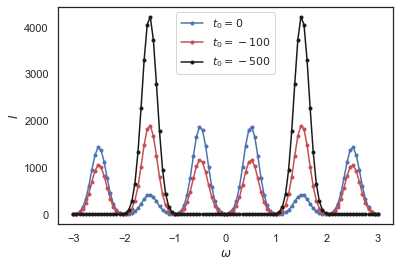

In [623]:
plt.figure()
plt.plot((ws0_ana+wf)/Omega,Ps0_ana,c='b',marker='.',label=r"$t_0 = 0$")
plt.plot((ws1_ana+wf)/Omega,Ps1_ana,c='r',marker='.',label=r"$t_0 = -100$")
plt.plot((ws5_ana+wf)/Omega,Ps5_ana,c='k',marker='.',label=r"$t_0 = -500$")
plt.legend()

plt.xlabel(r"$\omega$")
plt.ylabel(r"$I$")

plt.show()

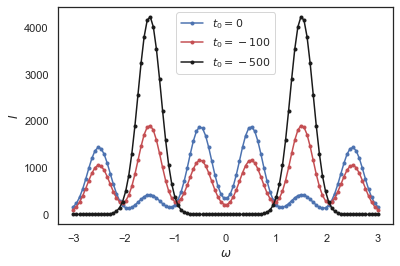

In [347]:
plt.figure()
plt.plot((ws0_ana+wf)/Omega,Ps0_ana,c='b',marker='.',label=r"$t_0 = 0$")
plt.plot((ws1_ana+wf)/Omega,Ps1_ana,c='r',marker='.',label=r"$t_0 = -100$")
plt.plot((ws5_ana+wf)/Omega,Ps5_ana,c='k',marker='.',label=r"$t_0 = -500$")
plt.legend()

plt.xlabel(r"$\omega$")
plt.ylabel(r"$I$")

plt.show()

I think there is a mistake in the paper. If we take $v_F = 3.6/\hbar$ and put a factor of $1/\hbar$ into $A_{eff}$, the results don't match up to the ones in the paper (although this is the correct way of doing it). 

# Wavefunctions

Compare the wavefunctions.

First, analytic (assuming $T_{pump} \gg T$):

In [477]:
def WavefunctionAnalytic(t,tr,a,kx,ky,v,mu,eE0,Omega,Tpump):
    """
    Analytically defined wavefunction
    tr -> -\infty
    a is +/- 1
    """
    phases = np.exp(-1j*(a*v*kx-mu/hbar)*(t-tr))
    Aint = eE0/(Omega**2)*(np.exp(-t**2/(2*Tpump**2))*np.sin(Omega*t) - np.exp(-tr**2/(2*Tpump**2))*np.sin(Omega*tr))
    Aphase = np.exp(1j*a*v*Aint/hbar)
    spinor = np.array([1.,a*1j])/np.sqrt(2)
    psi = phases*Aphase*spinor
    return psi

In [399]:
tr=-500
t=-405

t_temp = np.linspace(tr,t,10000)
expcos = lambda tp: eE0/Omega * np.exp(-tp**2/(2*Tpump**2)) * np.cos(Omega*tp)
Aint_simpson = simpson(expcos(t_temp),t_temp)
Aint_quad = quad(func=expcos,a=tr,b=t)[0]
Aint_approx = eE0/Omega**2*(np.exp(-t**2/(2*Tpump**2))*np.sin(Omega*t) - np.exp(-tr**2/(2*Tpump**2))*np.sin(Omega*tr))

In [400]:
Aint_simpson

0.00015135544647528094

In [401]:
Aint_quad

0.0001513554464882212

In [402]:
Aint_approx

0.00015578716498897295

In [433]:
kx=0.0
ky=0.
t_space = np.linspace(-500,500,num=1001)
psi_ana = np.zeros((2,1001),dtype=complex)
for i in range(1001):
    t = t_space[i]
    psi_ana[:,i] = WavefunctionAnalytic(t=t,tr=-500,a=1,kx=kx,ky=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump)

In [506]:
Es,phis=InitialConditions(kx=kx,ky=ky,v=v,mu=mu)
psi_test = solve_ivp(fun=fun, t_span=[-500,500], 
                     y0=np.array([1,1j])/np.sqrt(2), args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45', 
                     max_step=1, atol = 1, rtol = 1)

(-100.0, 100.0)

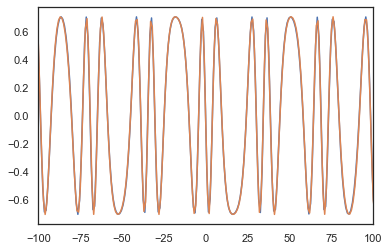

In [507]:
plt.plot(psi_test.t,psi_test.y[0,:].real)
plt.plot(t_space,psi_ana.real[0])
plt.xlim(-100,100)

# Semi-analytic

Use analytic wavefunction in numerical procedure. Compare numerical with semi-numerical.

In [637]:
def PhotocurrentSASemi(psi,ts,s,kx,ky,w,t0,Tprobe):
    # t-sapce
    # integrand: enveloppe * phase * psi
    integrand = Enveloppe(t_space,t0,Tprobe) * np.exp(1j*w*ts) * psi[s,:]
    # integrate samples data using simpson's rule
    I = simpson(integrand) # optional: x=t_space
    return np.abs(I)**2

def PhotocurrentSemi(kx,ky,w,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Main photocurrent function
    """
    # start by diagonalizing time-independent system
    Es, phis = InitialConditions(kx,ky,v=v,mu=mu)
    
    # solve ODE
    ts = np.linspace(-500,500,num=1001)
    psi0 = np.zeros((2,1001),dtype=complex)
    psi1 = np.zeros((2,1001),dtype=complex)
    for i in range(1001):
        t = ts[i]
        psi0[:,i] = WavefunctionAnalytic(t=t,tr=-500,a=1,kx=kx,ky=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump)
        psi1[:,i] = WavefunctionAnalytic(t=t,tr=-500,a=-1,kx=kx,ky=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump)
    
    # integrate and add it up
    P = 0
    for s in range(2):
        # add up both spins
        P += Fermi(Es[0],kT=1e-4) * PhotocurrentSASemi(psi=psi0,ts=ts,s=s,kx=kx,ky=ky,w=w,t0=t0,Tprobe=Tprobe)
        P += Fermi(Es[1],kT=1e-4) * PhotocurrentSASemi(psi=psi1,ts=ts,s=s,kx=kx,ky=ky,w=w,t0=t0,Tprobe=Tprobe)
    return P

def PhotocurrentArraySemi(kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in kx-w plane 
    """
    res = 100
    
    ws = np.linspace(-3,3,res)*Omega - mu/hbar # from inverting (w-wF)/Omega
    P = np.zeros(res,dtype=float)
    for i in range(res):
        w = ws[i]
        P[i] = PhotocurrentSemi(kx,ky,w,t0,v,mu,eE0,Omega,Tpump,Tprobe)
            
    return ws, P

In [638]:
# semi-analytic
ws_semi, Ps_semi = PhotocurrentArraySemi(kx=0.05,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
# numerical
ws_num, Ps_num = PhotocurrentArray(kx=0.05,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
# analytic
ws_ana,Ps_ana=PhotocurrentAnalyticArray(kx=0.05,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

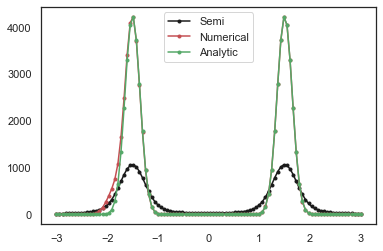

In [639]:
plt.plot((ws_semi+wf)/Omega,Ps_semi,c='k',marker='.',label="Semi")
plt.plot((ws_num+wf)/Omega,Ps_num,c='r',marker='.',label="Numerical")
plt.plot((ws_ana+wf)/Omega,Ps_ana,c='g',marker='.',label="Analytic")
plt.legend()
plt.show()

Area isn't conserved because enveloppe function is cut off.

# Green functions

Verify that the Green functions are the same

In [567]:
# numerically
kx=0
ky=0

# get the wavefunctions for all t
psi_plus = solve_ivp(fun=fun, t_span=[-500,500],
                     y0=np.array([1,1j])/np.sqrt(2), args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45',
                     max_step=0.1, atol = 1, rtol = 1)
psi_minus = solve_ivp(fun=fun, t_span=[-500,500],
                      y0=np.array([1,-1j])/np.sqrt(2), args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45',
                      max_step=0.1, atol = 1, rtol = 1)

def Gnum(t1,t2,psi_plus,psi_minus,kx,ky,v,mu,eE0,Omega,Tpump):

    # get the indices for the given times
    t1ind_plus = np.argmin(np.abs(psi_plus.t-t1))
    t2ind_plus = np.argmin(np.abs(psi_plus.t-t2))
    t1ind_minus = np.argmin(np.abs(psi_minus.t-t1))
    t2ind_minus = np.argmin(np.abs(psi_minus.t-t2))
    
    # get the wavefunctions at those times
    psi_plus_t1 = psi_plus.y[:,t1ind_plus]
    psi_plus_t2 = psi_plus.y[:,t2ind_plus]
    psi_minus_t1 = psi_minus.y[:,t1ind_minus]
    psi_minus_t2 = psi_minus.y[:,t2ind_minus]
    
    # compute the Green function by adding up the outer products
    # note we assume f = 1 always (low-temperature limit)
    G = np.outer(psi_plus_t1,psi_plus_t2.conj().T) + np.outer(psi_minus_t1,psi_minus_t2.conj().T)
    G *= 1j
    
    return G

In [568]:
# analytic
def Gana(t1,t2,kx,v,mu,eE0,Omega,Tpump):
    G = np.zeros((2,2),dtype=complex)
    for a in [-1,1]:
        # bare phase factor
        phase = np.exp(-1j*(a*v*kx - mu/hbar)*(t1-t2))
        # pump phase factor
        Aint = eE0/(Omega**2)*(np.exp(-t1**2/(2*Tpump**2))*np.sin(Omega*t1) - np.exp(-t2**2/(2*Tpump**2))*np.sin(Omega*t2))
        Aphase = np.exp(1j*a*v*Aint/hbar)
        # spinor
        spinor = np.array([1.,a*1j])/np.sqrt(2)
        # add up the phase * spinor outer product
        G += phase*Aphase*np.outer(spinor,spinor.conj().T)
        
    G *= 1j
        
    return G

In [569]:
Gana(t1=0,t2=5,kx=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump)

array([[ 0.06851787-0.05866766j, -0.75649927+0.64774398j],
       [ 0.75649927-0.64774398j,  0.06851787-0.05866766j]])

In [570]:
Gnum(t1=0,t2=5,psi_plus=psi_plus,psi_minus=psi_minus,kx=0.0,ky=0,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump)

array([[ 0.06763945-0.05791551j, -0.75657827+0.64781163j],
       [ 0.75657827-0.64781163j,  0.06763945-0.05791551j]])

# More debugging (clean lateR)

Compute the integral explicitly now.

In [599]:


def DoubleIntegral(w,kx,ky,t0,v,mu,eE0,Omega,Tpump,Tprobe):
    # compute the wavefunctions
    psi_plus = solve_ivp(fun=fun, t_span=[-250,250],
                         y0=np.array([1,1j])/np.sqrt(2), args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45',
                         max_step=0.1, atol = 1, rtol = 1)
    psi_minus = solve_ivp(fun=fun, t_span=[-250,250],
                          y0=np.array([1,-1j])/np.sqrt(2), args=(kx,ky,v,mu,eE0,Omega,Tpump), method='RK45',
                          max_step=0.1, atol = 1, rtol = 1)
    
    # define the enveloppe function
    s = lambda t: np.exp(-(t-t0)**2/(2*Tprobe**2))
    
    # define a lambda function with arguments only (t1,t2)
    integrand = lambda t1, t2: s(t1)*s(t2)*np.exp(1j*w*(t1-t2))*np.trace(Gnum(t1=t1,t2=t2,
                                                                                  psi_plus=psi_plus,psi_minus=psi_minus,
                                                                                  kx=kx,ky=ky,v=v,mu=mu,eE0=eE0,
                                                                                  Omega=Omega,Tpump=Tpump))

    # make 2D array of Integrand for (t1,t2) values
    N = 501
    t1s = np.linspace(-250,250,num=N)
    t2s = np.linspace(-250,250,num=N)
    integrand_sampled = np.zeros((N,N),dtype=complex)
    
    print("starting to fill array")
    
    for i,t1 in enumerate(t1s):
        print("filled {}th row".format(i))
        for j,t2 in enumerate(t2s):
            integrand_sampled[i,j] = integrand(t1,t2)
            
    print("done filling array")
            
    # integrate each row (corresponding to fixed value of t1)
    I = np.zeros(N,dtype=complex)
    for i in range(N):
        print("integrated {}th row".format(i))
        I[i] = simpson(integrand_sampled[i,:],x=t2s)
        
    # do final integral
    II = simpson(I,x=t1s)
    
    # integrate it
#     double_integral = dblquad(integrand,-500,500,-500,500)
    
    return np.imag(II)
    
    
    
    

In [600]:
DoubleIntegral(w=2.5,kx=0,ky=0,t0=-500,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

starting to fill array
filled 0th row
filled 1th row
filled 2th row
filled 3th row
filled 4th row
filled 5th row
filled 6th row
filled 7th row
filled 8th row
filled 9th row
filled 10th row
filled 11th row
filled 12th row
filled 13th row
filled 14th row
filled 15th row
filled 16th row
filled 17th row
filled 18th row
filled 19th row
filled 20th row
filled 21th row
filled 22th row
filled 23th row
filled 24th row
filled 25th row
filled 26th row
filled 27th row
filled 28th row
filled 29th row
filled 30th row
filled 31th row
filled 32th row
filled 33th row
filled 34th row
filled 35th row
filled 36th row
filled 37th row
filled 38th row
filled 39th row
filled 40th row
filled 41th row
filled 42th row
filled 43th row
filled 44th row
filled 45th row
filled 46th row
filled 47th row
filled 48th row
filled 49th row
filled 50th row
filled 51th row
filled 52th row
filled 53th row
filled 54th row
filled 55th row
filled 56th row
filled 57th row
filled 58th row
filled 59th row
filled 60th row
filled 61th

filled 488th row
filled 489th row
filled 490th row
filled 491th row
filled 492th row
filled 493th row
filled 494th row
filled 495th row
filled 496th row
filled 497th row
filled 498th row
filled 499th row
filled 500th row
done filling array
integrated 0th row
integrated 1th row
integrated 2th row
integrated 3th row
integrated 4th row
integrated 5th row
integrated 6th row
integrated 7th row
integrated 8th row
integrated 9th row
integrated 10th row
integrated 11th row
integrated 12th row
integrated 13th row
integrated 14th row
integrated 15th row
integrated 16th row
integrated 17th row
integrated 18th row
integrated 19th row
integrated 20th row
integrated 21th row
integrated 22th row
integrated 23th row
integrated 24th row
integrated 25th row
integrated 26th row
integrated 27th row
integrated 28th row
integrated 29th row
integrated 30th row
integrated 31th row
integrated 32th row
integrated 33th row
integrated 34th row
integrated 35th row
integrated 36th row
integrated 37th row
integrated

7.885503577076741e-41

My own integrator

In [251]:
def RK4_step(fun,t,y,h,kx,ky,v,mu,eE0,Omega,Tpump):
    """
    Fixed step RK4 integrator
    fun and y are 2-component functions/arrays
    """
    # define a simple function of two arguments
    psi = lambda t, y : fun(t,y,kx,ky,v,mu,eE0,Omega,Tpump)
    
    # compute the next step
    k1 = psi(t,y) * h
    k2 = psi(t+h/2,y+k1/2) * h
    k3 = psi(t+h/2,y+k2/2) * h
    k4 = psi(t+h,y+k3) * h
    dy = (k1+2*k2+2*k3+k4)/6
    
    # return it
    return y+dy

def EvolvePsi(fun,psi_initial,t_span,h,kx,ky,v,mu,eE0,Omega,Tpump):
    """
    Time-evolves psi through the dirac equation
    """
    Nt = int((t_span[1]-t_span[0])/h)
    ts = np.linspace(t_span[0], t_span[1], Nt)
    
    psi = np.zeros((Nt,2),dtype=complex)
    psi[0,:] = psi_initial
    
    for i,t in enumerate(ts[:Nt-1]):
        y0 = psi[i,:]
        psi[i+1,:] = RK4_step(fun=fun,t=t,y=y0,h=h,kx=kx,ky=ky,v=v,mu=mu,eE0=eE0,Omega=Omega,Tpump=Tpump)
        
    return ts, psi

# Speed up the code
By not computing the wavefunction every loop.